# Treinamento de Detecção de Pneumonia com PyTorch

Este notebook implementa o pipeline completo de treinamento usando PyTorch, incluindo carregamento de dados, definição do modelo EfficientNet, loop de treinamento e visualização com Grad-CAM.

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Adicionar diretório raiz ao path para importar src
sys.path.append(os.path.abspath('..'))

from src.dataset_loader import get_dataloaders
from src.model_pytorch import PneumoniaClassifier
from src.train_pytorch import train_model
from src.gradcam_pytorch import GradCAM, show_cam_on_image

## 1. Configuração e Carregamento de Dados

In [2]:
# Configurar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Diretório dos dados
DATA_DIR = '../data/raw/chest_xray/chest_xray'

# Carregar DataLoaders
dataloaders, dataset_sizes, class_names = get_dataloaders(DATA_DIR, batch_size=32)

print(f"Tamanhos dos datasets: {dataset_sizes}")
print(f"Classes: {class_names}")

Usando dispositivo: cuda:0
Tamanhos dos datasets: {'train': 5216, 'val': 16, 'test': 624}
Classes: ['NORMAL', 'PNEUMONIA']


## 2. Definição do Modelo

Utilizamos EfficientNet-B0 pré-treinada na ImageNet, substituindo o classificador final.

In [3]:
model = PneumoniaClassifier(num_classes=1, freeze_backbone=True)
model = model.to(device)

## 3. Treinamento

Usamos BCEWithLogitsLoss para estabilidade numérica e Adam como otimizador.

In [4]:
criterion = nn.BCEWithLogitsLoss()

# Otimizar apenas os parâmetros do classificador (backbone congelado)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Treinar
model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)

Epoch 1/10
----------


train: 100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


train Loss: 0.3388 Acc: 0.8696
val Loss: 0.4108 Acc: 0.8125
Melhor modelo salvo!

Epoch 2/10
----------


train: 100%|██████████| 163/163 [00:31<00:00,  5.24it/s]


train Loss: 0.2187 Acc: 0.9214
val Loss: 0.3711 Acc: 0.8125
Melhor modelo salvo!

Epoch 3/10
----------


train: 100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


train Loss: 0.2047 Acc: 0.9237
val Loss: 0.4200 Acc: 0.8125

Epoch 4/10
----------


train: 100%|██████████| 163/163 [00:50<00:00,  3.21it/s]


train Loss: 0.1860 Acc: 0.9308
val Loss: 0.4898 Acc: 0.8125

Epoch 5/10
----------


train: 100%|██████████| 163/163 [00:33<00:00,  4.88it/s]


train Loss: 0.1755 Acc: 0.9317
val Loss: 0.4406 Acc: 0.8125

Epoch 6/10
----------


train: 100%|██████████| 163/163 [00:31<00:00,  5.17it/s]


train Loss: 0.1708 Acc: 0.9342
val Loss: 0.4019 Acc: 0.8125

Epoch 7/10
----------


train: 100%|██████████| 163/163 [00:30<00:00,  5.34it/s]


train Loss: 0.1600 Acc: 0.9381
val Loss: 0.4015 Acc: 0.8125

Epoch 8/10
----------


train: 100%|██████████| 163/163 [00:30<00:00,  5.27it/s]


train Loss: 0.1617 Acc: 0.9411
val Loss: 0.3970 Acc: 0.8125

Epoch 9/10
----------


train: 100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


train Loss: 0.1540 Acc: 0.9427
val Loss: 0.4045 Acc: 0.8125

Epoch 10/10
----------


train: 100%|██████████| 163/163 [00:30<00:00,  5.32it/s]


train Loss: 0.1537 Acc: 0.9431
val Loss: 0.3768 Acc: 0.8750

Treinamento completo em 6m 36s
Melhor Val Loss: 0.3711 Acc: 0.8125


### Visualizar Histórico de Treinamento

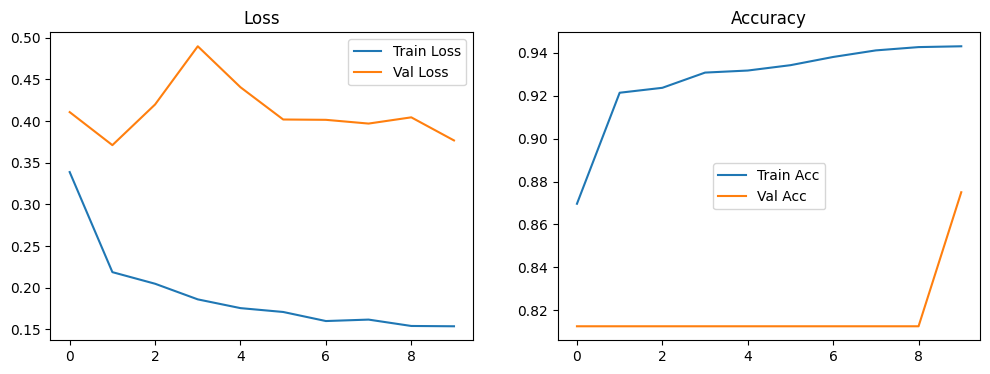

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

## 4. Fine-Tuning (Opcional)

Descongelar o backbone e treinar com learning rate menor.

In [6]:
model.unfreeze()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

model, history_ft = train_model(model, dataloaders, criterion, optimizer, num_epochs=5, device=device)

Epoch 1/5
----------


train: 100%|██████████| 163/163 [00:45<00:00,  3.59it/s]


train Loss: 0.1648 Acc: 0.9400
val Loss: 0.2999 Acc: 0.8750
Melhor modelo salvo!

Epoch 2/5
----------


train: 100%|██████████| 163/163 [00:43<00:00,  3.72it/s]


train Loss: 0.1332 Acc: 0.9492
val Loss: 0.2782 Acc: 0.8750
Melhor modelo salvo!

Epoch 3/5
----------


train: 100%|██████████| 163/163 [00:43<00:00,  3.75it/s]


train Loss: 0.1144 Acc: 0.9592
val Loss: 0.3128 Acc: 0.8750

Epoch 4/5
----------


train: 100%|██████████| 163/163 [00:43<00:00,  3.74it/s]


train Loss: 0.0953 Acc: 0.9663
val Loss: 0.2148 Acc: 0.8750
Melhor modelo salvo!

Epoch 5/5
----------


train: 100%|██████████| 163/163 [00:43<00:00,  3.73it/s]


train Loss: 0.0837 Acc: 0.9699
val Loss: 0.2688 Acc: 0.8750

Treinamento completo em 4m 6s
Melhor Val Loss: 0.2148 Acc: 0.8750


## 5. Avaliação e Grad-CAM

Visualizar onde o modelo está "olhando" para tomar a decisão.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


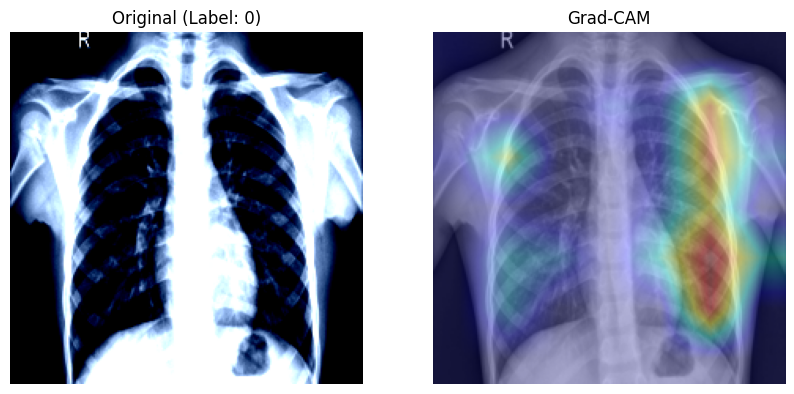

In [7]:
# Pegar um batch de teste
inputs, labels = next(iter(dataloaders['test']))
inputs = inputs.to(device)

# Instanciar Grad-CAM na última camada convolucional
# Para EfficientNetB0 do torchvision, é features[-1]
target_layer = model.backbone.features[-1]
grad_cam = GradCAM(model, target_layer)

# Gerar CAM para a primeira imagem do batch
idx = 0
img_tensor = inputs[idx].unsqueeze(0)
cam = grad_cam(img_tensor)

# Visualizar
result_img = show_cam_on_image(inputs[idx], cam)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(inputs[idx].permute(1, 2, 0).cpu())
plt.title(f"Original (Label: {labels[idx].item()})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()